In [0]:
!mkdir kaggle

In [2]:
!pip install kaggle

In [0]:
import os
os.chdir('../root')

In [0]:
!mkdir .kaggle

In [0]:
os.chdir('.kaggle')

In [0]:
import json
token ={"username":"","key":""}
with open('kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!chmod 600 kaggle.json

In [8]:
!kaggle datasets list

ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
new-york-state/nys-environmental-remediation-sites          NYS Environmental Remediation Sites                   6MB  2019-08-09 08:27:31           2129  
eliasdabbas/search-engine-results-flights-tickets-keywords  Search Engine Results - Flights & Tickets Keywords   22MB  2019-08-01 11:51:13           1565  
google/google-landmarks-dataset                             Google-Landmarks Dataset                            107MB  2019-08-09 12:00:27          10831  
new-york-city/new-york-city-current-job-postings            New York City Current Job Postings                    3MB  2019-08-04 22:04:44           6265  
AnalyzeBoston/crimes-in-boston                              Crim

In [0]:
os.chdir('../../content/kaggle')

In [10]:
!ls -la

total 8
drwxr-xr-x 2 root root 4096 Aug  9 12:29 .
drwxr-xr-x 1 root root 4096 Aug  9 12:29 ..


In [11]:
!kaggle datasets download -d authman/pickled-crawl300d2m-for-kernel-competitions

100% 1.69G/1.69G [00:08<00:00, 233MB/s]
100% 1.69G/1.69G [00:08<00:00, 206MB/s]


In [12]:
!kaggle datasets download -d authman/pickled-glove840b300d-for-10sec-loading

100% 2.33G/2.33G [00:12<00:00, 201MB/s]
100% 2.33G/2.33G [00:12<00:00, 201MB/s]


In [13]:
!unzip pickled-crawl300d2m-for-kernel-competitions.zip

Archive:  pickled-crawl300d2m-for-kernel-competitions.zip
  inflating: crawl-300d-2M.pkl       


In [14]:
!unzip pickled-glove840b300d-for-10sec-loading.zip

Archive:  pickled-glove840b300d-for-10sec-loading.zip
  inflating: glove.840B.300d.pkl     


In [15]:
!git clone https://github.com/Tariq60/LIAR-PLUS.git

Cloning into 'LIAR-PLUS'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 77 (delta 2), reused 0 (delta 0), pack-reused 68
Unpacking objects: 100% (77/77), done.


In [16]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2019-08-09 12:33:34--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.37.150
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.37.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  70.9MB/s    in 24s     

2019-08-09 12:33:59 (65.3 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
!gunzip GoogleNews-vectors-negative300.bin.gz

In [0]:
os.chdir('..')

In [0]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
from gensim.parsing.preprocessing import STOPWORDS
import pickle
from tqdm import tqdm
tqdm.pandas()

COLUMN_NAMES = ['id', 'label', 'statement', 'subject', 'speaker',
               'speakers_job', 'state_info', 'party_aff', 'bt_cnt',
               'f_cnt', 'ht_cnt', 'mt_cnt', 'pf_cnt', 'context',
               'justification']

BATCH_SIZE = 256

GLOVE_EMBEDDING_PATH = 'kaggle/glove.840B.300d.pkl'
CRAWL_EMBEDDING_PATH = 'kaggle/crawl-300d-2M.pkl'
DATA_PATH = 'kaggle/LIAR-PLUS/'

BASIC_FEAT_PERCENTILE = 95

In [43]:
! ls -la

total 20
drwxr-xr-x 1 root root 4096 Aug  9 12:29 .
drwxr-xr-x 1 root root 4096 Aug  9 12:27 ..
drwxr-xr-x 1 root root 4096 Aug  7 16:05 .config
drwxr-xr-x 3 root root 4096 Aug  9 12:34 kaggle
drwxr-xr-x 1 root root 4096 Aug  2 16:06 sample_data


In [44]:
train = pd.read_csv(DATA_PATH + 'dataset/train2.tsv', sep = '\t', names = COLUMN_NAMES)
test = pd.read_csv(DATA_PATH + 'dataset/test2.tsv', sep = '\t', names = COLUMN_NAMES)
valid = pd.read_csv(DATA_PATH + 'dataset/val2.tsv', sep = '\t', names = COLUMN_NAMES)

train['justification'].fillna('Empty', inplace = True)
test['justification'].fillna('Empty', inplace = True)
valid['justification'].fillna('Empty', inplace = True)
print(train.shape, test.shape, valid.shape)
data = pd.DataFrame(np.vstack([train.values, valid.values, test.values]), columns = COLUMN_NAMES)
print(data.shape)

(10240, 15) (1267, 15) (1284, 15)
(12791, 15)


In [0]:
# Binary label translation
label_dict = {
    'half-true': 0,
    'false': 0,
    'mostly-true': 1,
    'true': 1,
    'barely-true': 1,
    'pants-fire': 0
}

data['binary_label'] = data['label'].map(label_dict)

In [0]:
for index, value in enumerate(data['label']):
    if value == 'pants-fire':
        data.loc[index, 'pf_cnt'] -= 1
    elif value == 'false':
        data.loc[index, 'f_cnt'] -= 1
    elif value == 'half-true':
        data.loc[index, 'ht_cnt'] -= 1
    elif value == 'barely-true':
        data.loc[index, 'bt_cnt'] -= 1
    elif value == 'mostly-true':
        data.loc[index, 'mt_cnt'] -= 1

### Load best embeddigs from EDA

In [0]:
import operator 

# TAKEN FROM https://www.kaggle.com/christofhenkel/how-to-preprocessing-for-glove-part1-eda

def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [0]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')


def load_embeddings(path):
    with open(path,'rb') as f:
        emb_arr = pickle.load(f)
    return emb_arr

def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

In [50]:
import time 
tic = time.time()
crawl_embeddings = load_embeddings(CRAWL_EMBEDDING_PATH)
print(f'loaded {len(crawl_embeddings)} word vectors in {time.time()-tic}s')

loaded 2000000 word vectors in 13.546377420425415s


In [0]:
symbols_to_isolate = '.,?!-;*"…:—()%#$&_/@＼・ω+=”“[]^–>\\°<~•≠™ˈʊɒ∞§{}·τα❤☺ɡ|¢→̶`❥━┣┫┗Ｏ►★©―ɪ✔®\x96\x92●£♥➤´¹☕≈÷♡◐║▬′ɔː€۩۞†μ✒➥═☆ˌ◄½ʻπδηλσερνʃ✬ＳＵＰＥＲＩＴ☻±♍µº¾✓◾؟．⬅℅»Вав❣⋅¿¬♫ＣＭβ█▓▒░⇒⭐›¡₂₃❧▰▔◞▀▂▃▄▅▆▇↙γ̄″☹➡«φ⅓„✋：¥̲̅́∙‛◇✏▷❓❗¶˚˙）сиʿ✨。ɑ\x80◕！％¯−ﬂﬁ₁²ʌ¼⁴⁄₄⌠♭✘╪▶☭✭♪☔☠♂☃☎✈✌✰❆☙○‣⚓年∎ℒ▪▙☏⅛ｃａｓǀ℮¸ｗ‚∼‖ℳ❄←☼⋆ʒ⊂、⅔¨͡๏⚾⚽Φ×θ￦？（℃⏩☮⚠月✊❌⭕▸■⇌☐☑⚡☄ǫ╭∩╮，例＞ʕɐ̣Δ₀✞┈╱╲▏▕┃╰▊▋╯┳┊≥☒↑☝ɹ✅☛♩☞ＡＪＢ◔◡↓♀⬆̱ℏ\x91⠀ˤ╚↺⇤∏✾◦♬³の｜／∵∴√Ω¤☜▲↳▫‿⬇✧ｏｖｍ－２０８＇‰≤∕ˆ⚜☁'
symbols_to_delete = '\n🍕\r🐵😑\xa0\ue014\t\uf818\uf04a\xad😢🐶️\uf0e0😜😎👊\u200b\u200e😁عدويهصقأناخلىبمغر😍💖💵Е👎😀😂\u202a\u202c🔥😄🏻💥ᴍʏʀᴇɴᴅᴏᴀᴋʜᴜʟᴛᴄᴘʙғᴊᴡɢ😋👏שלוםבי😱‼\x81エンジ故障\u2009🚌ᴵ͞🌟😊😳😧🙀😐😕\u200f👍😮😃😘אעכח💩💯⛽🚄🏼ஜ😖ᴠ🚲‐😟😈💪🙏🎯🌹😇💔😡\x7f👌ἐὶήιὲκἀίῃἴξ🙄Ｈ😠\ufeff\u2028😉😤⛺🙂\u3000تحكسة👮💙فزط😏🍾🎉😞\u2008🏾😅😭👻😥😔😓🏽🎆🍻🍽🎶🌺🤔😪\x08‑🐰🐇🐱🙆😨🙃💕𝘊𝘦𝘳𝘢𝘵𝘰𝘤𝘺𝘴𝘪𝘧𝘮𝘣💗💚地獄谷улкнПоАН🐾🐕😆ה🔗🚽歌舞伎🙈😴🏿🤗🇺🇸мυтѕ⤵🏆🎃😩\u200a🌠🐟💫💰💎эпрд\x95🖐🙅⛲🍰🤐👆🙌\u2002💛🙁👀🙊🙉\u2004ˢᵒʳʸᴼᴷᴺʷᵗʰᵉᵘ\x13🚬🤓\ue602😵άοόςέὸתמדףנרךצט😒͝🆕👅👥👄🔄🔤👉👤👶👲🔛🎓\uf0b7\uf04c\x9f\x10成都😣⏺😌🤑🌏😯ех😲Ἰᾶὁ💞🚓🔔📚🏀👐\u202d💤🍇\ue613小土豆🏡❔⁉\u202f👠》कर्मा🇹🇼🌸蔡英文🌞🎲レクサス😛外国人关系Сб💋💀🎄💜🤢َِьыгя不是\x9c\x9d🗑\u2005💃📣👿༼つ༽😰ḷЗз▱ц￼🤣卖温哥华议会下降你失去所有的钱加拿大坏税骗子🐝ツ🎅\x85🍺آإشء🎵🌎͟ἔ油别克🤡🤥😬🤧й\u2003🚀🤴ʲшчИОРФДЯМюж😝🖑ὐύύ特殊作戦群щ💨圆明园קℐ🏈😺🌍⏏ệ🍔🐮🍁🍆🍑🌮🌯🤦\u200d𝓒𝓲𝓿𝓵안영하세요ЖљКћ🍀😫🤤ῦ我出生在了可以说普通话汉语好极🎼🕺🍸🥂🗽🎇🎊🆘🤠👩🖒🚪天一家⚲\u2006⚭⚆⬭⬯⏖新✀╌🇫🇷🇩🇪🇮🇬🇧😷🇨🇦ХШ🌐\x1f杀鸡给猴看ʁ𝗪𝗵𝗲𝗻𝘆𝗼𝘂𝗿𝗮𝗹𝗶𝘇𝗯𝘁𝗰𝘀𝘅𝗽𝘄𝗱📺ϖ\u2000үսᴦᎥһͺ\u2007հ\u2001ɩｙｅ൦ｌƽｈ𝐓𝐡𝐞𝐫𝐮𝐝𝐚𝐃𝐜𝐩𝐭𝐢𝐨𝐧Ƅᴨןᑯ໐ΤᏧ௦Іᴑ܁𝐬𝐰𝐲𝐛𝐦𝐯𝐑𝐙𝐣𝐇𝐂𝐘𝟎ԜТᗞ౦〔Ꭻ𝐳𝐔𝐱𝟔𝟓𝐅🐋ﬃ💘💓ё𝘥𝘯𝘶💐🌋🌄🌅𝙬𝙖𝙨𝙤𝙣𝙡𝙮𝙘𝙠𝙚𝙙𝙜𝙧𝙥𝙩𝙪𝙗𝙞𝙝𝙛👺🐷ℋ𝐀𝐥𝐪🚶𝙢Ἱ🤘ͦ💸ج패티Ｗ𝙇ᵻ👂👃ɜ🎫\uf0a7БУі🚢🚂ગુજરાતીῆ🏃𝓬𝓻𝓴𝓮𝓽𝓼☘﴾̯﴿₽\ue807𝑻𝒆𝒍𝒕𝒉𝒓𝒖𝒂𝒏𝒅𝒔𝒎𝒗𝒊👽😙\u200cЛ‒🎾👹⎌🏒⛸公寓养宠物吗🏄🐀🚑🤷操美𝒑𝒚𝒐𝑴🤙🐒欢迎来到阿拉斯ספ𝙫🐈𝒌𝙊𝙭𝙆𝙋𝙍𝘼𝙅ﷻ🦄巨收赢得白鬼愤怒要买额ẽ🚗🐳𝟏𝐟𝟖𝟑𝟕𝒄𝟗𝐠𝙄𝙃👇锟斤拷𝗢𝟳𝟱𝟬⦁マルハニチロ株式社⛷한국어ㄸㅓ니͜ʖ𝘿𝙔₵𝒩ℯ𝒾𝓁𝒶𝓉𝓇𝓊𝓃𝓈𝓅ℴ𝒻𝒽𝓀𝓌𝒸𝓎𝙏ζ𝙟𝘃𝗺𝟮𝟭𝟯𝟲👋🦊多伦🐽🎻🎹⛓🏹🍷🦆为和中友谊祝贺与其想象对法如直接问用自己猜本传教士没积唯认识基督徒曾经让相信耶稣复活死怪他但当们聊些政治题时候战胜因圣把全堂结婚孩恐惧且栗谓这样还♾🎸🤕🤒⛑🎁批判检讨🏝🦁🙋😶쥐스탱트뤼도석유가격인상이경제황을렵게만들지않록잘관리해야합다캐나에서대마초와화약금의품런성분갈때는반드시허된사용🔫👁凸ὰ💲🗯𝙈Ἄ𝒇𝒈𝒘𝒃𝑬𝑶𝕾𝖙𝖗𝖆𝖎𝖌𝖍𝖕𝖊𝖔𝖑𝖉𝖓𝖐𝖜𝖞𝖚𝖇𝕿𝖘𝖄𝖛𝖒𝖋𝖂𝕴𝖟𝖈𝕸👑🚿💡知彼百\uf005𝙀𝒛𝑲𝑳𝑾𝒋𝟒😦𝙒𝘾𝘽🏐𝘩𝘨ὼṑ𝑱𝑹𝑫𝑵𝑪🇰🇵👾ᓇᒧᔭᐃᐧᐦᑳᐨᓃᓂᑲᐸᑭᑎᓀᐣ🐄🎈🔨🐎🤞🐸💟🎰🌝🛳点击查版🍭𝑥𝑦𝑧ＮＧ👣\uf020っ🏉ф💭🎥Ξ🐴👨🤳🦍\x0b🍩𝑯𝒒😗𝟐🏂👳🍗🕉🐲چی𝑮𝗕𝗴🍒ꜥⲣⲏ🐑⏰鉄リ事件ї💊「」\uf203\uf09a\uf222\ue608\uf202\uf099\uf469\ue607\uf410\ue600燻製シ虚偽屁理屈Г𝑩𝑰𝒀𝑺🌤𝗳𝗜𝗙𝗦𝗧🍊ὺἈἡχῖΛ⤏🇳𝒙ψՁմեռայինրւդձ冬至ὀ𝒁🔹🤚🍎𝑷🐂💅𝘬𝘱𝘸𝘷𝘐𝘭𝘓𝘖𝘹𝘲𝘫کΒώ💢ΜΟΝΑΕ🇱♲𝝈↴💒⊘Ȼ🚴🖕🖤🥘📍👈➕🚫🎨🌑🐻𝐎𝐍𝐊𝑭🤖🎎😼🕷ｇｒｎｔｉｄｕｆｂｋ𝟰🇴🇭🇻🇲𝗞𝗭𝗘𝗤👼📉🍟🍦🌈🔭《🐊🐍\uf10aლڡ🐦\U0001f92f\U0001f92a🐡💳ἱ🙇𝗸𝗟𝗠𝗷🥜さようなら🔼'

In [0]:
from nltk.tokenize.treebank import TreebankWordTokenizer
def preprocess_data(train):
    t1 = time.time()
    
    isolate_dict = {ord(c):f' {c} ' for c in symbols_to_isolate}
    remove_dict = {ord(c):f'' for c in symbols_to_delete}
    

    def handle_punctuation(x):
        x = x.translate(remove_dict)
        x = x.translate(isolate_dict)
        return x

    train['statement'] = train['statement'].progress_apply(lambda x: handle_punctuation(x))
    train['justification'] = train['justification'].progress_apply(lambda x: handle_punctuation(x))
    
    tokenizer = TreebankWordTokenizer()
    def handle_contractions(x):
        x = tokenizer.tokenize(x)
        x = ' '.join(x)
        return x

    train['statement'] = train['statement'].progress_apply(lambda x:handle_contractions(x))
    train['justification'] = train['justification'].progress_apply(lambda x:handle_contractions(x))
    def fix_quote(x):
        x = [x_[1:] if x_.startswith("'") else x_ for x_ in x]
        x = ' '.join(x)
        return x

    train['statement'] = train['statement'].progress_apply(lambda x:fix_quote(x.split()))
    train['justification'] = train['justification'].progress_apply(lambda x:fix_quote(x.split()))
    
    print(f'Preprocess took {time.time() - t1}')
    return train

In [53]:
data = preprocess_data(data)

100%|██████████| 12791/12791 [00:00<00:00, 44461.54it/s]

Preprocess took 7.020262718200684


In [54]:
vocab_statement = build_vocab(list(data['statement'].apply(lambda x:x.split())))
oov_statement = check_coverage(vocab_statement,crawl_embeddings)
oov_statement[:10]

100%|██████████| 15424/15424 [00:00<00:00, 878419.28it/s]

Found embeddings for 95.96% of vocab
Found embeddings for  99.27% of all text


[('``', 1108),
 ("n't", 149),
 ('jsonmostly', 12),
 ('jsonhalf', 11),
 ('Kasichs', 11),
 ('trueSays', 5),
 ('Crists', 5),
 ('jsonbarely', 5),
 ('Cornilles', 5),
 ('jsontrueSays', 4)]

In [55]:
vocab_justification = build_vocab(list(data['justification'].apply(lambda x:x.split())))
oov_justification = check_coverage(vocab_justification,crawl_embeddings)
oov_justification[:10]

100%|██████████| 28976/28976 [00:00<00:00, 615708.84it/s]

Found embeddings for 94.77% of vocab
Found embeddings for  97.79% of all text


[('``', 19018),
 ("n't", 1588),
 ('sharethefacts', 556),
 ('PolitiFactRI', 115),
 ('2196f3', 55),
 ('politifactri', 37),
 ('Kasichs', 34),
 ('_', 33),
 ('McAuliffes', 27),
 ('Gingrichs', 26)]

### Data preprocessing

In [0]:
from sklearn.preprocessing import LabelEncoder
COLUMNS_TO_PROCESS = ['subject', 'speaker', 'speakers_job', 'state_info', 'party_aff', 'context']

def preprocess(d):
    data = d.copy()
    lc = LabelEncoder()
    for col in COLUMNS_TO_PROCESS:
        data[col] = data[col].fillna('Other')
        col_dict = data[col].value_counts()
        data[col].apply(lambda x: x if col_dict[x] > np.percentile(col_dict.values, BASIC_FEAT_PERCENTILE) else 'Other')
        data[col] = lc.fit_transform(data[col])
    return data
data = preprocess(data)

In [0]:
from sklearn.model_selection import train_test_split
label_dict = {
    'half-true': 2,
    'false': 1,
    'mostly-true': 4,
    'true': 5,
    'barely-true': 3,
    'pants-fire': 0
}

try:
    data = data.drop(columns = 'id')
except:
    pass
data['label'] = data['label'].map(label_dict)
tr, vl, te = data.iloc[train.index, :], data.iloc[train.index[-1] + valid.index, :], data.iloc[train.index[-1] + valid.index[-1] + test.index, :]

In [0]:
from keras.utils import to_categorical
tr_st, tr_justi, tr_add, tr_label = tr['statement'], tr['justification'], tr.loc[:, 'subject': 'context'], to_categorical(tr.loc[:, 'label'])
val_st, val_justi, val_add, val_label = vl['statement'], vl['justification'], vl.loc[:, 'subject': 'context'], to_categorical(vl.loc[:, 'label'])
te_st, te_justi, te_add, te_label = te['statement'], te['justification'], te.loc[:, 'subject': 'context'], to_categorical(te.loc[:, 'label'])

### Build model

In [0]:
from keras.preprocessing import text, sequence
max_features = 400000
MAX_LEN = 300
tokenizer = text.Tokenizer(num_words = max_features, filters='', lower=False)
vals_to_tokenize = list(tr_st) + list(tr_justi) + list(val_st) + list(val_justi) + list(te_st) + list(te_justi)
tokenizer.fit_on_texts(vals_to_tokenize)

tr_st = tokenizer.texts_to_sequences(tr_st)
tr_justi = tokenizer.texts_to_sequences(tr_justi)
val_st = tokenizer.texts_to_sequences(val_st)
val_justi = tokenizer.texts_to_sequences(val_justi)
te_st = tokenizer.texts_to_sequences(te_st)
te_justi = tokenizer.texts_to_sequences(te_justi)

tr_st = sequence.pad_sequences(tr_st, maxlen=MAX_LEN)
tr_justi = sequence.pad_sequences(tr_justi, maxlen=MAX_LEN)
val_st = sequence.pad_sequences(val_st, maxlen=MAX_LEN)
val_justi = sequence.pad_sequences(val_justi, maxlen=MAX_LEN)
te_st = sequence.pad_sequences(te_st, maxlen=MAX_LEN)
te_justi = sequence.pad_sequences(te_justi, maxlen=MAX_LEN)

In [60]:
import gc
# get embeddings
crawl_matrix, unknown_words_crawl = build_matrix(tokenizer.word_index, CRAWL_EMBEDDING_PATH)
print('n unknown words (crawl): ', len(unknown_words_crawl))

max_features = max_features or len(tokenizer.word_index) + 1
gc.collect()

n unknown words (crawl):  2044


0

In [0]:
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
from keras.metrics import binary_accuracy, categorical_accuracy, sparse_categorical_accuracy
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping

LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS

def build_model(embedding_matrix, normal_feats_shape = 11):
    # ----------- Statements network input
    statements = Input(shape=(None,))
    
    x1 = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(statements)
    # x1 = SpatialDropout1D(0.2)(x1)
    # x1 = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x1)
    x1 = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x1)
    
    hidden1 = concatenate([
        GlobalMaxPooling1D()(x1),
        GlobalAveragePooling1D()(x1),
    ])
    
    hidden1 = add([hidden1, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden1)])
    hidden1 = add([hidden1, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden1)])
    
    # ----------- Justifications network input
    
    justifications = Input(shape = (None, ))
    
    x2 = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(justifications)
    x2 = SpatialDropout1D(0.2)(x2)
    x2 = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x2)
    x2 = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x2)
    
    hidden2 = concatenate([
        GlobalMaxPooling1D()(x2),
        GlobalAveragePooling1D()(x2),
    ])
    
    hidden2 = add([hidden2, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden2)])
    hidden2 = add([hidden2, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden2)])
    
    # ------------------- Other features network input
    
    norm_input = Input(shape = (normal_feats_shape, ))
    x3 = Dense(8, activation = 'sigmoid')(norm_input)
    
    # ------- Connecting all 3 branches in one
    
    hidden = concatenate([hidden1, hidden2, x3])
    result = Dense(6, activation='sigmoid')(hidden)
    
    model = Model(inputs=[statements, justifications, norm_input], outputs=[result])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = [categorical_accuracy])

    return model

In [62]:
model = build_model(crawl_matrix)

from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint(filepath='multi.h5', verbose = 1, save_best_only=True)
stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')

model.fit(
            [tr_st, tr_justi, tr_add],
            [tr_label],
            batch_size=BATCH_SIZE,
            validation_data = ([val_st, val_justi, val_add], val_label),
            epochs=12,
            verbose=1,
            callbacks=[checkpointer, stop]
        )

Train on 10240 samples, validate on 1284 samples
Epoch 1/12
10240/10240 [==============================] - 15s 1ms/step - loss: 1.7420 - categorical_accuracy: 0.2190 - val_loss: 1.7079 - val_categorical_accuracy: 0.2539

Epoch 00001: val_loss improved from inf to 1.70788, saving model to multi.h5
Epoch 2/12
10240/10240 [==============================] - 13s 1ms/step - loss: 1.6929 - categorical_accuracy: 0.2535 - val_loss: 1.6876 - val_categorical_accuracy: 0.2562

Epoch 00002: val_loss improved from 1.70788 to 1.68755, saving model to multi.h5
Epoch 3/12
10240/10240 [==============================] - 13s 1ms/step - loss: 1.6502 - categorical_accuracy: 0.2756 - val_loss: 1.6885 - val_categorical_accuracy: 0.2757

Epoch 00003: val_loss did not improve from 1.68755
Epoch 4/12
10240/10240 [==============================] - 13s 1ms/step - loss: 1.5652 - categorical_accuracy: 0.3250 - val_loss: 1.7123 - val_categorical_accuracy: 0.2625

Epoch 00004: val_loss did not improve from 1.68755
Epo

In [0]:
model_json = model.to_json()
with open("multi.json", "w") as json_file:
    json_file.write(model_json)

In [64]:
from sklearn.metrics import accuracy_score, confusion_matrix

te_label = te.loc[:, 'label']
test_preds = np.argmax(model.predict([te_st, te_justi, te_add]), axis = 1)

# print('ROC AUC {}'.format(roc_auc_score(te_label, test_preds)))
print('Accuracy {}'.format(accuracy_score(te_label, test_preds)))

Accuracy 0.24546172059984214


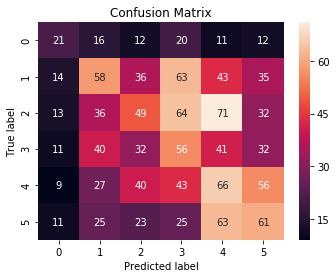

In [65]:
confusion = confusion_matrix(te_label, test_preds)
cm_df = pd.DataFrame(confusion)

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()